### Let's continue working with [Dataset](https://www.kaggle.com/alexmamaev/flowers-recognition ) for the classification of flowers (tulip, chamomile, sunflower, rose, dandelion).

# Preparing a dataset and functions for training

Loading libraries. Fixing random.seed for reproducibility

In [32]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

We choose what we will do calculations on - CPU or GPU (cuda)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [19]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #we bring the pictures to the same size
        torchvision.transforms.ToTensor(), #packing them into a tensor
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] #normalize images by channels
        ),
    ]
)
#setting the dataset. Labels - folder names:
dataset = ImageFolder('/Users/pavel/Desktop/flowers', transform=prepare_imgs)

In [20]:
dataset.imgs[2]

('/Users/pavel/Desktop/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [21]:
class ValueMeter(object):
  """
  Auxiliary class to track loss and metric
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


### Setting parameters and function for training. Splitting the dataset into train/validation

In [22]:
batch_size = 32 # batch size
lr = 0.001 # learning rate

Splitting the dataset into train and validation

Setting data loaders - objects for iterative loading of data and labels for training and validation

In [23]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('The size of the training and validation dataset: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

The size of the training and validation dataset:  3317 1000


Function for calculating Accuracy

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Function for training and validation of the model

In [25]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: the model we are going to train
    loaders: dictionary with dataloaders for training and validation
    optimizer: optimizer
    epochs: the number of training epochs (how many times will we go through the entire dataset)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # iterations by epoch
        for mode in ['training', 'validation']: # training - validation
            # calculating the gradient only on trainning:
            with torch.set_grad_enabled(mode == 'training'):
                # depending on the phase, we switch the model to the desired mode:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # sending tensor to CPU/GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # batch size (different for the last batch in loader)

                    preds = model(imgs) # forward pass - we run the tensor with pictures through the model
                    loss = F.cross_entropy(preds, labels) # calculating the loss function
                    acc = accuracy(preds, labels) # calculating metrics

                    # saving loss and accuracy for batch
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # if we are in the learning phase
                    if mode == 'training':
                        optimizer.zero_grad() # zero the previous gradient 
                        loss.backward() # doing backward pass (calculating the gradient)
                        optimizer.step() # update weights
            # at the end of the phase, we output the values of loss and accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # saving results for every epoch
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

In [26]:
def set_parameter_requires_grad(model):
  """
  Function fot freezing model weights
  """
  for param in model.parameters():
    param.requires_grad = False

# Homework

In the homework, we will try to teach another convolutional architecture.

1) Analyze in more detail the code above (or the code from practice, they are identical). Run all the code in this laptop.


2) See how [convolutional network models are set in PyTorch](https://pytorch.org/vision/stable/models.html ), select one model from the list:

*   alexnet
*   vgg16
*   mobilenet_v2
*   mobilenet_v3_small
*   densenet

3) Retrain the selected model for the color classification task, by analogy with how we retrained resnet18 in class. To do this, replace ____ in the cells below with the code. Somewhere it is necessary to insert the necessary variable, somewhere to register a constant. The main thing is not to be scared! A similar code can be found in a laptop with practice ;)

4) If you are interested, read more about these architectures. You can read [here (in English)](https://medium.com/@fransiska26/the-differences-between-inception-resnet-and-mobilenet-e97736a709b0 ) or [here (in Russian)](https://habr.com/ru/company/nix/blog/430524/)

In [27]:
# Choose the model from the list of available in PyTorch models
# Don't forget to tag that the model could be pre-trained!
model = torchvision.models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
# pass the model to the function to "freeze" the gradient
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model)

In [29]:
# model.fc = nn.Linear(4096, 5)# Changing the last layer of the model
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)

In [30]:
# Let's check if everything worked correctly, output the weights that will be trained
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.6.weight
classifier.6.bias


In [31]:
model.to(device) # send model to CPU/GPU
optimizer = torch.optim.Adam(params = model.parameters()) # optimization algorithm 
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) # we start training, set the number of epochs

100%|██████████| 104/104 [00:48<00:00,  2.15it/s]


[training] Epoch: 0.00. Loss: 0.58. Accuracy: 78.99% 


100%|██████████| 32/32 [00:22<00:00,  1.45it/s]


[validation] Epoch: 0.00. Loss: 0.41. Accuracy: 86.40% 


100%|██████████| 104/104 [00:52<00:00,  2.00it/s]


[training] Epoch: 1.00. Loss: 0.45. Accuracy: 83.51% 


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[validation] Epoch: 1.00. Loss: 0.42. Accuracy: 86.00% 


100%|██████████| 104/104 [00:45<00:00,  2.28it/s]


[training] Epoch: 2.00. Loss: 0.38. Accuracy: 86.09% 


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


[validation] Epoch: 2.00. Loss: 0.42. Accuracy: 86.10% 


100%|██████████| 104/104 [00:48<00:00,  2.16it/s]


[training] Epoch: 3.00. Loss: 0.34. Accuracy: 87.78% 


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


[validation] Epoch: 3.00. Loss: 0.42. Accuracy: 86.35% 


100%|██████████| 104/104 [00:42<00:00,  2.43it/s]


[training] Epoch: 4.00. Loss: 0.31. Accuracy: 88.88% 


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


[validation] Epoch: 4.00. Loss: 0.42. Accuracy: 86.54% 


100%|██████████| 104/104 [00:41<00:00,  2.52it/s]


[training] Epoch: 5.00. Loss: 0.28. Accuracy: 89.53% 


100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


[validation] Epoch: 5.00. Loss: 0.42. Accuracy: 86.62% 


100%|██████████| 104/104 [00:42<00:00,  2.46it/s]


[training] Epoch: 6.00. Loss: 0.26. Accuracy: 90.26% 


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


[validation] Epoch: 6.00. Loss: 0.42. Accuracy: 86.63% 


100%|██████████| 104/104 [00:43<00:00,  2.40it/s]


[training] Epoch: 7.00. Loss: 0.25. Accuracy: 90.85% 


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


[validation] Epoch: 7.00. Loss: 0.43. Accuracy: 86.68% 


100%|██████████| 104/104 [00:41<00:00,  2.49it/s]


[training] Epoch: 8.00. Loss: 0.23. Accuracy: 91.41% 


100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


[validation] Epoch: 8.00. Loss: 0.43. Accuracy: 86.62% 


100%|██████████| 104/104 [00:41<00:00,  2.50it/s]


[training] Epoch: 9.00. Loss: 0.22. Accuracy: 91.89% 


100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

[validation] Epoch: 9.00. Loss: 0.43. Accuracy: 86.68% 


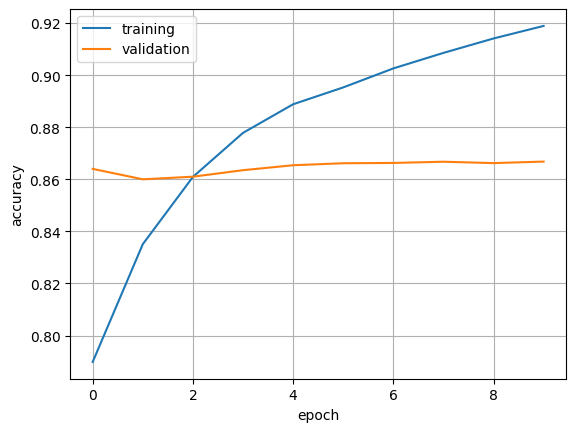

In [33]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()